# 混合ガウスモデル
---

主に多峰性がみられるデータのクラスタリングなどに使用される．\
ちなみにこれの簡単なバージョンがK-meansである．
<br/>
最終的には解析的に解が得られないため，パラメータの更新によって近似解を求める．

ライブラリ

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

データ

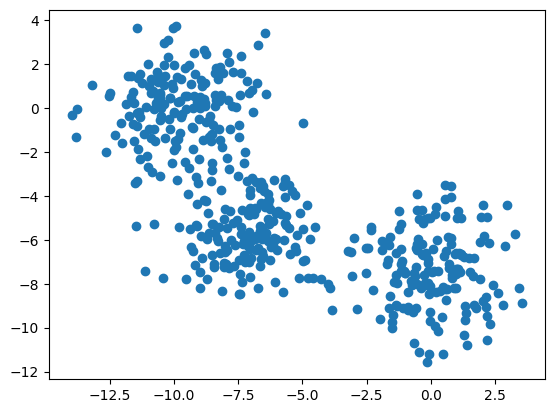

In [5]:
d = 2 # 次元数
K = 3 # クラス数
N = 500 #データの数

X, y = make_blobs(
    n_samples=N,
    n_features=d,
    centers=K,
    cluster_std=1.5,
    random_state=9,
)
plt.scatter(X[:, 0], X[:, 1]);

本家

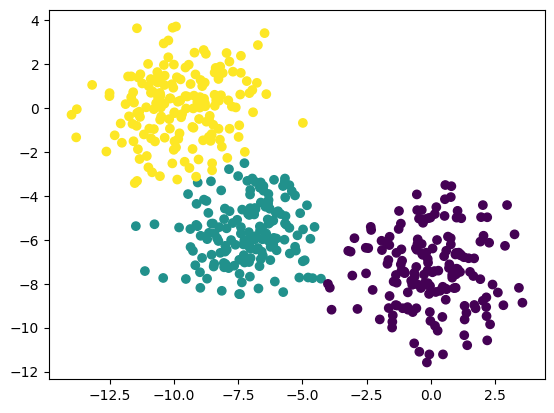

In [6]:
gmm = GaussianMixture(n_components=K)
gmm.fit(X)
clusters = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters);

実践

- n_componentsはK
- max_iterは繰り返す回数(今回繰り返す回数は指定する)

$\pi_k$は混合比率．(全体での)比率\
$\gamma_k$は負担率．観測値が各クラスで得られたと仮定したときの確率

In [30]:
class GaussianMixture:
    def __init__(self, n_components, max_iter=100): #モデルをインスタンス化するときに渡す引数はクラスの数と繰り返し回数(更新回数)である．
        self.n_components = n_components
        self.max_iter = max_iter

    def _init_params(self, d): # モデルの最初はまずパラメータを初期化しなくてはならない．
        self.mu = np.random.rand(self.n_components, d) # 平均はK,×dの行列．(平均だけはランダムでないとうまくかないらしい)
        self.sigma =  np.eye(d)[np.newaxis].repeat(self.n_components, axis=0) # K,×d×dのテンソルを作成．ここには後から求めた数値を入れるので単位テンソルで十分．
        self.pi = np.ones(self.n_components)/self.n_components # K,の一様分布．和は1でなければならない．これは混合比率なので．

    def _get_gamma(self, X): # この_get_gammaで負担率を求めている．ここがとても大事．
        J = [] # 各データに対して，(クラスKで得られたと仮定したときの混合比率)
        for k in range(self.n_components): # 各クラスについて考える
            J.append(self.pi[k] * multivariate_normal.pdf(X, self.mu[k], self.sigma[k])) #そのまま数式をかく．
        return np.array(J) / np.sum(J,axis=0) # (負担率)=(クラスKで得られたと仮定したときの混合比率)/(全体の混合比率) axis=0で列ごとに和をとっている．


    def fit(self, X):
        # 学習部分
        N, d = X.shape # データ数と次元数を取得する．
        self._init_params(d) #ここでパラメータが初期化されている．
        for _ in range(self.max_iter):
            gamma = self._get_gamma(X) # K,×Nの行列
            Nk = np.sum(gamma,axis=1) # K,の配列になる
            self.mu = (gamma @ X) / Nk.reshape(-1, 1) # K行d列
            for k in range(self.n_components):
                sigma_k = gamma[k] * (X - self.mu[k]).T @ (X - self.mu[k]) / Nk[k] #gamma[k] * (X - self.mu[k]).Tが先に計算されて，d×Nになる．
                self.sigma[k] = sigma_k # K,×d×dでおいておいたsigmaの値を各クラスのigmaの値に置き換える
            self.pi = Nk / N #　混合比率を更新する．



    def predict(self, X):
        # 推論部分
        return np.argmax(self._get_gamma(X), 0) # K,× Nの行列の中から各列ごとに一番大きい値を採用する．
    # その他必要なメソッド（あれば）

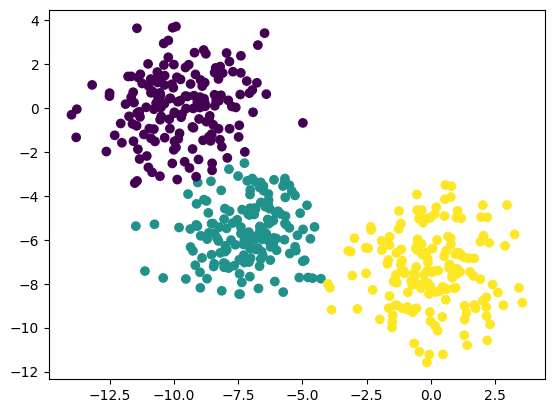

In [52]:
gmm_ = GaussianMixture(n_components=3)
gmm_.fit(X)
clusters = gmm_.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters)